# Funzioni

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)
  print_accuracy(y_test, y_pred, display_labels=estimator.classes_)
  return y_pred

def print_accuracy(y_test, y_pred, display_labels=None):
  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(cmn, display_labels=display_labels).plot()

In [43]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [44]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    ret = pd.concat([dataset.drop(columns=columns), dummies], axis=1)
  else:
    ret = pd.concat([dataset, dummies], axis=1)
  return ret

In [45]:
def xtab(rows_data, cols_data, normalize_rows=False):
  xtab = pd.crosstab(rows_data, cols_data)
  if normalize_rows:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / (rows_data == i).sum()
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

In [46]:
def voting_classifier(estimators, X_train_list, y_train_list, X_test):
    
    preds = np.asarray([clf.fit(X, y).predict(X_test) for clf, X, y in 
                        zip(estimators, X_train_list, y_train_list)])
    modes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 
                                axis=0, arr=preds)
    
    return modes

# Parte 1: Analisi

### 1

In [47]:
dataset = pd.read_csv('healthcarestrokedata.csv')

In [48]:
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [50]:
data = dataset.stroke
data.value_counts() / len(data)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

### 2

In [51]:
dataset.dropna(inplace=True)

In [52]:
data = dataset.stroke
data.value_counts() / len(data)

0    0.957425
1    0.042575
Name: stroke, dtype: float64

Il dataset rimane ugualmente sbilancaito

### 3

In [53]:
dataset.age.max()

82.0

In [54]:
dataset['age_bins'] = pd.cut(dataset.age, bins=(0, 45, 90), right=False)

In [55]:
pd.pivot_table(dataset, values='stroke', index='age_bins', columns='gender')

gender,Female,Male,Other
age_bins,,,
"[0, 45)",0.004084,0.00201,0.0
"[45, 90)",0.079832,0.08563,NaN


### 4

stroke               0         1
hypertension                    
0             0.966577  0.033423
1             0.866962  0.133038


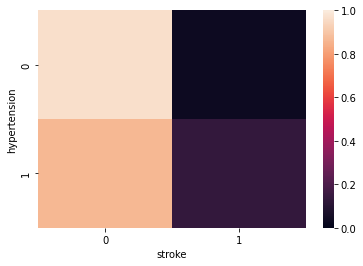

In [56]:
_ = xtab(dataset.hypertension, dataset.stroke, normalize_rows=True)

In [57]:
pd.pivot_table(dataset, values='stroke', index='hypertension', columns='gender')

gender,Female,Male,Other
hypertension,,,
0,0.031368,0.036444,0.0
1,0.147410,0.115000,NaN


### 5

In [58]:
dataset.age.min()

0.08

In [59]:
dataset['age_bins'] = pd.cut(dataset.age, bins=range(0, 90, 5))

stroke           0         1
age_bins                    
(0, 5]    1.000000  0.000000
(5, 10]   1.000000  0.000000
(10, 15]  0.995726  0.004274
(15, 20]  1.000000  0.000000
(20, 25]  1.000000  0.000000
(25, 30]  1.000000  0.000000
(30, 35]  0.996805  0.003195
(35, 40]  0.988060  0.011940
(40, 45]  0.986226  0.013774
(45, 50]  0.971671  0.028329
(50, 55]  0.964115  0.035885
(55, 60]  0.927807  0.072193
(60, 65]  0.953704  0.046296
(65, 70]  0.887500  0.112500
(70, 75]  0.891892  0.108108
(75, 80]  0.819620  0.180380
(80, 85]  0.800000  0.200000


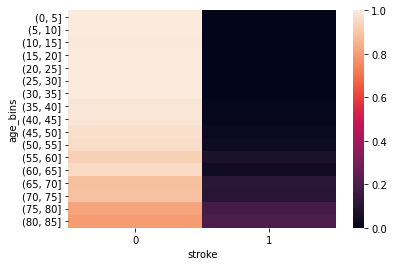

In [60]:
_ = xtab(dataset.age_bins, dataset.stroke, normalize_rows=True)

# Parte 2: Trasformazione e Predizione

### 1

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [61]:
dataset = pd.read_csv('healthcarestrokedata.csv')

dataset.dropna(inplace=True);
dataset.reset_index(drop=True, inplace=True)

dataset.drop(columns='id', inplace=True)

Rimuovo ID perchè causa branching inutile senza aggiungere alcuna informazione

In [62]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 422.0+ KB


In [63]:
dataset.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [64]:
categorical = dataset.columns[dataset.dtypes == 'object']

In [65]:
categorical

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [66]:
dataset1 = add_dummies(dataset, categorical)

In [67]:
dataset1.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,Female,Other,Yes,No,Private,Self-employed,Govt_job,children,Never_worked,Urban,Rural,formerly smoked,never smoked,smokes,Unknown
0,67.0,0,1,228.69,36.6,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,80.0,0,1,105.92,32.5,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,49.0,0,0,171.23,34.4,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,79.0,1,0,174.12,24.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,81.0,0,0,186.21,29.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [68]:
X = dataset1.drop(columns='stroke')
y = dataset1.stroke

In [69]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=.75, random_state=1)

Accuracy: 1.0
Confusion matrix:
 [[3530    0]
 [   0  151]]


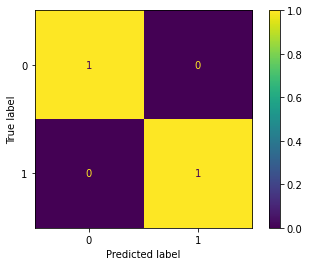

In [73]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.9169381107491856
Confusion matrix:
 [[1118   52]
 [  50    8]]
Balanced accuracy: 0.5467432950191571


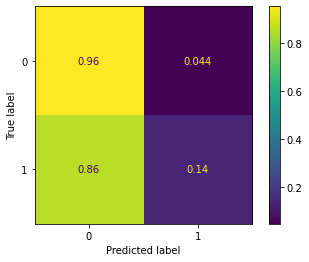

In [81]:
y_pr = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_ts, y_pr))

Accuracy: 0.9592502037489813
Confusion matrix:
 [[3530    0]
 [ 150    1]]


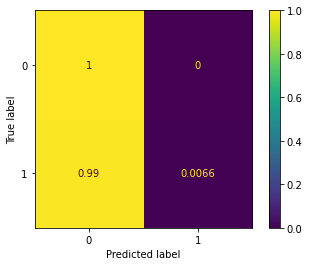

In [75]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, LogisticRegression(n_jobs=-1))

Accuracy: 0.9527687296416938
Confusion matrix:
 [[1170    0]
 [  58    0]]
Balanced accuracy: 0.5


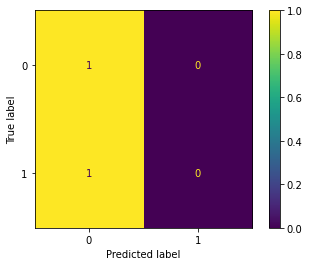

In [82]:
y_pr = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, LogisticRegression(n_jobs=-1))
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_ts, y_pr))

Accuracy: 0.9589785384406412
Confusion matrix:
 [[3530    0]
 [ 151    0]]


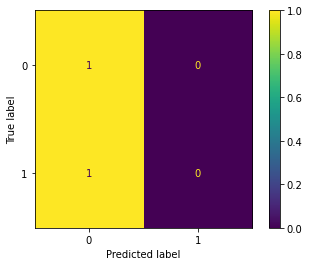

In [77]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DummyClassifier())

Accuracy: 0.9527687296416938
Confusion matrix:
 [[1170    0]
 [  58    0]]
Balanced accuracy: 0.5


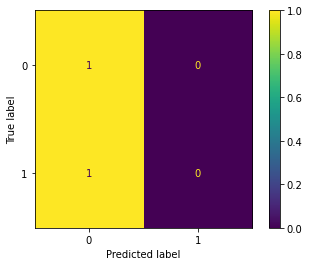

In [83]:
y_pr = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DummyClassifier())
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_ts, y_pr))

L'accuratezza risulta elevata perchè il dataset è estremamente sbilanciato, ma dalla confusion map si evince che solo la classe prevalente (0) viene predeta correttamente.
Una metrica più indicativa è la balanced_accuracy, che equivale alla recall per classe con macroaverage

### 2

In [84]:
acc_dt = cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy',
                         cv=5, n_jobs=-1).mean()
acc_lr = cross_val_score(LogisticRegression(), X, y, scoring='accuracy',
                         cv=5, n_jobs=-1).mean()
acc_dc = cross_val_score(DummyClassifier(), X, y, scoring='accuracy',
                         cv=5, n_jobs=-1).mean()

In [85]:
print('Decision Tree:', acc_dt)
print('Logistic Regression:', acc_lr)
print('Dummy Classifier:', acc_dc)

Decision Tree: 0.9138326783219253
Logistic Regression: 0.9574255041304127
Dummy Classifier: 0.9574252965198238


L'accuratezza non cambia sensibilmente. Rimane elevata causa sbilanciamento del dataset

### 3

In [87]:
from sklearn.model_selection import GridSearchCV

In [92]:
param_grid = {
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
}

In [93]:
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy',
                  n_jobs=-1, cv=10, verbose=3).fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [94]:
gs.best_params_

{'min_samples_leaf': 4, 'min_samples_split': 2}

In [95]:
gs.best_score_

0.9431655513529241

### 4

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [192]:
dataset2 = pd.read_csv('healthcarestrokedata.csv')
dataset2.drop(columns='id', inplace=True)

In [193]:
columns = dataset2.columns.drop('stroke')
columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [194]:
categorical_idx = [ columns.get_loc(k) for k in categorical.drop('gender') ]
categorical_idx

[4, 5, 6, 9]

In [195]:
gender_idx = [columns.get_loc('gender')]
gender_idx

[0]

In [196]:
to_impute_idx = [columns.get_loc('bmi')]
to_impute_idx

[8]

In [209]:
ct = ColumnTransformer([
    ('imputer', SimpleImputer(), to_impute_idx),
    ('gender', OneHotEncoder(categories=[dataset2.gender.unique()]), 
     gender_idx),
    ('one_hot', OneHotEncoder(drop='if_binary'), categorical_idx)
])

In [210]:
X = dataset2.drop(columns='stroke')
y = dataset2.stroke

In [211]:
pipeline = Pipeline([
    # ('imputer', SimpleImputer()),
    ('pre_proc', ct),
    ('model', DecisionTreeClassifier())
])

In [212]:
param_grid = {
    'pre_proc__imputer__strategy': ['mean', 'median', 'most_frequent'],
}

In [213]:
gs = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3, 
                  n_jobs=-1, error_score='raise').fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [214]:
gs.best_params_

{'pre_proc__imputer__strategy': 'most_frequent'}

In [215]:
gs.best_score_

0.9095890410958904

### 5

In [216]:
dataset2 = pd.read_csv('healthcarestrokedata.csv')
dataset2.drop(columns='id', inplace=True)

smoking_status = {
    'Unknown': np.nan,
}

replace = {
    'smoking_status': smoking_status,
}

dataset2.replace(replace, inplace=True)

In [217]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [262]:
X = dataset2.drop(columns='stroke')
y = dataset2.stroke

In [263]:
columns = X.columns

In [275]:
to_impute_idx = [ columns.get_loc(k) for k in ['bmi', 'smoking_status'] ]
to_impute_idx

[8, 9]

In [276]:
categorical_idx = [ columns.get_loc(k) for k in categorical ]
categorical_idx

[0, 4, 5, 6, 9]

In [277]:
categories = []
for i in categorical_idx:
  categories.append(X.iloc[:, i].dropna().unique().tolist())
categories

[['Male', 'Female', 'Other'],
 ['Yes', 'No'],
 ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
 ['Urban', 'Rural'],
 ['formerly smoked', 'never smoked', 'smokes']]

In [278]:
imputer = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='most_frequent'), to_impute_idx)
], remainder='passthrough')

In [279]:
columns_after_imputing = ['bmi', 'smoking_status'] + columns.drop(
    ['bmi', 'smoking_status']).tolist()
columns_after_imputing = pd.Index(columns_after_imputing)

In [299]:
categorical_idx = [ columns_after_imputing.get_loc(k) for k in categorical ]
categorical_idx

[2, 6, 7, 8, 1]

In [285]:
one_hot = ColumnTransformer([
    ('one_hot', OneHotEncoder(categories=categories, drop='if_binary'), categorical_idx)
], remainder='passthrough')

In [286]:
pipeline = Pipeline([
    ('imputer', imputer),
    ('one_hot', one_hot),
    ('model', DecisionTreeClassifier())
])

In [287]:
cross_val_score(pipeline, X, y, cv=10, scoring='accuracy', n_jobs=-1).mean()

0.9066536203522505

### 6

In [290]:
from sklearn.preprocessing import KBinsDiscretizer, MaxAbsScaler

In [310]:
age_idx = [ columns_after_imputing.get_loc(k) for k in ['age'] ]
age_idx

[3]

In [311]:
glc_idx = [ columns_after_imputing.get_loc(k) for k in ['avg_glucose_level'] ]
glc_idx

[9]

In [297]:
categories

[['Male', 'Female', 'Other'],
 ['Yes', 'No'],
 ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
 ['Urban', 'Rural'],
 ['formerly smoked', 'never smoked', 'smokes']]

In [300]:
categorical_idx

[2, 6, 7, 8, 1]

In [312]:
ct = ColumnTransformer([
    ('one_hot', OneHotEncoder(categories=categories, drop='if_binary'), 
     categorical_idx),
    ('discr_age', KBinsDiscretizer(10), age_idx),
    ('discr_glc', KBinsDiscretizer(10), age_idx)
], remainder='passthrough')

In [313]:
pipeline = Pipeline([
    ('imputer', imputer),
    ('ct', ct),
    ('scaler', MaxAbsScaler()),
    ('model', DecisionTreeClassifier())
])

In [314]:
cross_val_score(pipeline, X, y, cv=10, scoring='accuracy', n_jobs=-1).mean()

0.9107632093933462

In [315]:
pipeline = Pipeline([
    ('imputer', imputer),
    ('ct', ct),
    ('scaler', MaxAbsScaler()),
    ('model', LogisticRegression(n_jobs=-1))
])

In [305]:
cross_val_score(pipeline, X, y, cv=10, scoring='accuracy', n_jobs=-1).mean()

0.9512720156555773

### 7

In [320]:
from sklearn.feature_selection import SelectKBest

In [321]:
pipeline = Pipeline([
    ('imputer', imputer),
    ('ct', ct),
    ('scaler', MaxAbsScaler()),
    ('select_k_best', SelectKBest()), 
    ('model', LogisticRegression(n_jobs=-1))
])

In [322]:
param_grid = {
    'select_k_best__k': [2, 4, 6],
    'ct__discr_age__n_bins': [2, 4, 6],
    'ct__discr_glc__n_bins': [2, 4, 6],
}

In [323]:
gs = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3, 
                  n_jobs=-1, error_score='raise').fit(X, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [324]:
gs.best_params_

{'ct__discr_age__n_bins': 2, 'ct__discr_glc__n_bins': 2, 'select_k_best__k': 2}

In [325]:
gs.best_score_

0.9512720156555773